In [101]:
# Starter

__author__ = "Philipp Kats"
from datetime import date
__date__ = date.today().strftime('%Y-%m-%d')

%matplotlib inline
import pylab as plt
plt.style.use('fivethirtyeight')

import pandas as pd
import geopandas as gp
import os
import json
import SE
import altair as alt

from tqdm import tqdm, tqdm_notebook
# tqdm().pandas()
#from hyperdash import monitor_cell, Experiment
 

from SE.areas import get_all_areas, get_larger_area
from SE.sql import _get_DF
from SE import definitions
#from SE.sql import queries
idx = pd.IndexSlice

print(__date__)
print(SE.__version__)

2018-09-11
5.8.6


In [102]:
from rasterio import features, Affine, float64
from rasterio.enums import MergeAlg
from xarray import DataArray
import numpy as np

import datashader as ds
from datashader import transfer_functions as tf, reductions as rd
from datashader.colors import Hot, viridis

import colorcet
kbc = colorcet.cm.kbc

In [103]:
def get_transform(cvs):
    '''transform into canvas coordinates'''
    return Affine((cvs.x_range[1] - cvs.x_range[0]) / cvs.plot_width, 0.0,
                   cvs.x_range[0], 0.0, (cvs.y_range[0] - cvs.y_range[1]) / cvs.plot_height, cvs.y_range[1])

In [104]:
from SE.spatial import get_better_boundaries, NYC_CRS, MERCATOR_CRS
nyc = get_better_boundaries(area_type='city', nyc_crs=True)

In [105]:
cb = pd.read_pickle('../data/correct_geom.pkl')

In [106]:
cb['boundary_name'] = cb['boundary_name'].str.lower()

## Borders

In [108]:
N = get_better_boundaries(area_type='neighborhood', nyc_crs=True)
UWS = N[N['name'].str.contains('West Side')].iloc[0]

In [117]:
mhtn = get_better_boundaries(area_type='borough', nyc_crs=True)
mhtn = mhtn[mhtn.name == 'Manhattan'].iloc[0]

## Upper West Side

In [107]:
uws = cb[cb.boundary_name.str.contains(r'uppper west|uws')]
len(uws)

7128

In [109]:
mask1 = uws.area <= 2*UWS.geometry.area
mask2 = uws.centroid.within(UWS.geometry)

In [110]:
uws2 = uws[mask1&mask2]

In [129]:
print(mhtn.geometry.centroid.buffer(20000).envelope)

POLYGON ((972972.9412307106 202850.9102338806, 1012972.941230711 202850.9102338806, 1012972.941230711 242850.9102338806, 972972.9412307106 242850.9102338806, 972972.9412307106 202850.9102338806))


In [130]:
cvs = ds.Canvas(plot_height=1000,
                plot_width=1000,
                x_range=(972972, 1012972),
                y_range=(202850, 242850))

aform = get_transform(cvs)
aform

Affine(40.0, 0.0, 972972.0,
       0.0, -40.0, 242850.0)

In [139]:
# borders
border = features.rasterize([(el, 1) for el in N['geometry'].boundary.tolist()] , 
                            out_shape=(cvs.plot_height, cvs.plot_width),
                            merge_alg=MergeAlg.replace, transform=aform, all_touched=True, dtype=float64)

border[border == 0] = np.nan
bd = DataArray(data=pd.np.flipud(border))

In [131]:
F = features.rasterize([(el, 1) for el in uws2['geometry'].tolist()],
                       out_shape=(cvs.plot_height, cvs.plot_width),
                       merge_alg=MergeAlg.add, transform=aform, dtype=float64)

df = DataArray(data=pd.np.flipud(F))

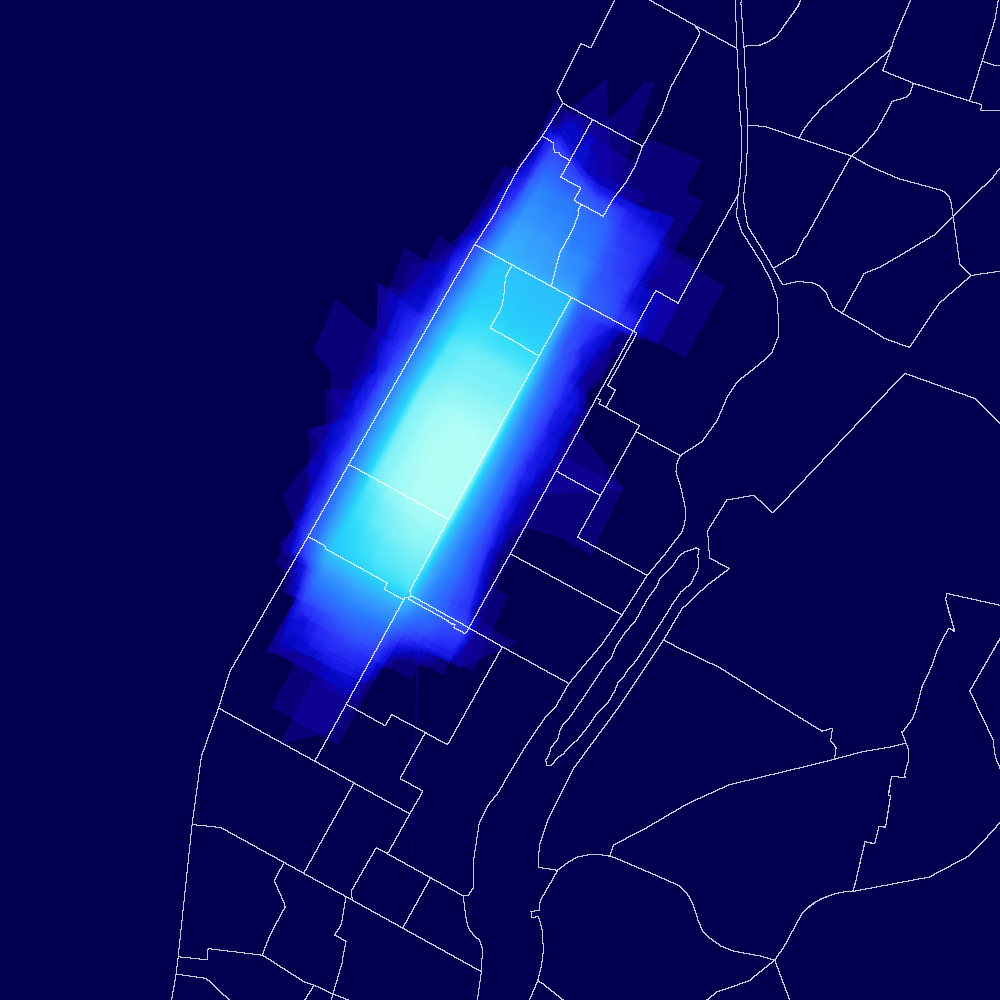

In [141]:
tf.stack(
    tf.shade(df, how='log', cmap=kbc, name='Density'),
    tf.shade(bd, how='eq_hist', cmap=['black','white'], alpha=200)
)

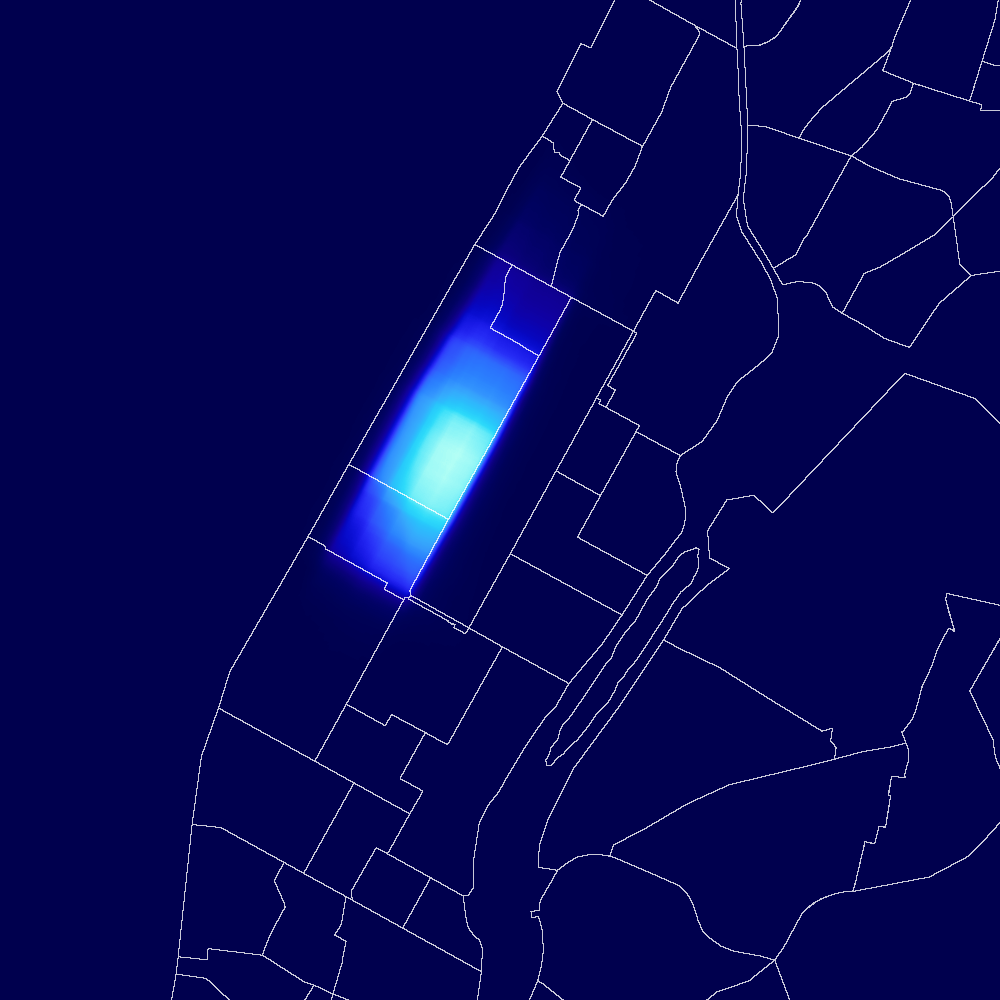

In [142]:
tf.stack(
    tf.shade(df, how='linear', cmap=kbc, name='Density'),
    tf.shade(bd, how='eq_hist', cmap=['black','white'], alpha=200)
)

## Crown Heights

In [143]:
nab = N[N['name'].str.contains('Crown Heights')].iloc[0]

In [153]:
print(nab.geometry.centroid.buffer(15000).envelope)

POLYGON ((985958.6518584291 168969.7083230907, 1015958.651858429 168969.7083230907, 1015958.651858429 198969.7083230907, 985958.6518584291 198969.7083230907, 985958.6518584291 168969.7083230907))


In [154]:
cvs = ds.Canvas(plot_height=1000,
                plot_width=1000,
                x_range=(985958, 1015958),
                y_range=(168969, 198969))

aform = get_transform(cvs)
aform

Affine(30.0, 0.0, 985958.0,
       0.0, -30.0, 198969.0)

In [155]:
# borders
border = features.rasterize([(el, 1) for el in N['geometry'].boundary.tolist()] , 
                            out_shape=(cvs.plot_height, cvs.plot_width),
                            merge_alg=MergeAlg.replace, transform=aform, all_touched=True, dtype=float64)

border[border == 0] = np.nan
bd = DataArray(data=pd.np.flipud(border))

In [156]:
ch = cb[cb.boundary_name.str.contains(r'crown')]
len(ch)

1057

In [157]:
F = features.rasterize([(el, 1) for el in ch['geometry'].tolist()],
                       out_shape=(cvs.plot_height, cvs.plot_width),
                       merge_alg=MergeAlg.add, transform=aform, dtype=float64)

df = DataArray(data=pd.np.flipud(F))

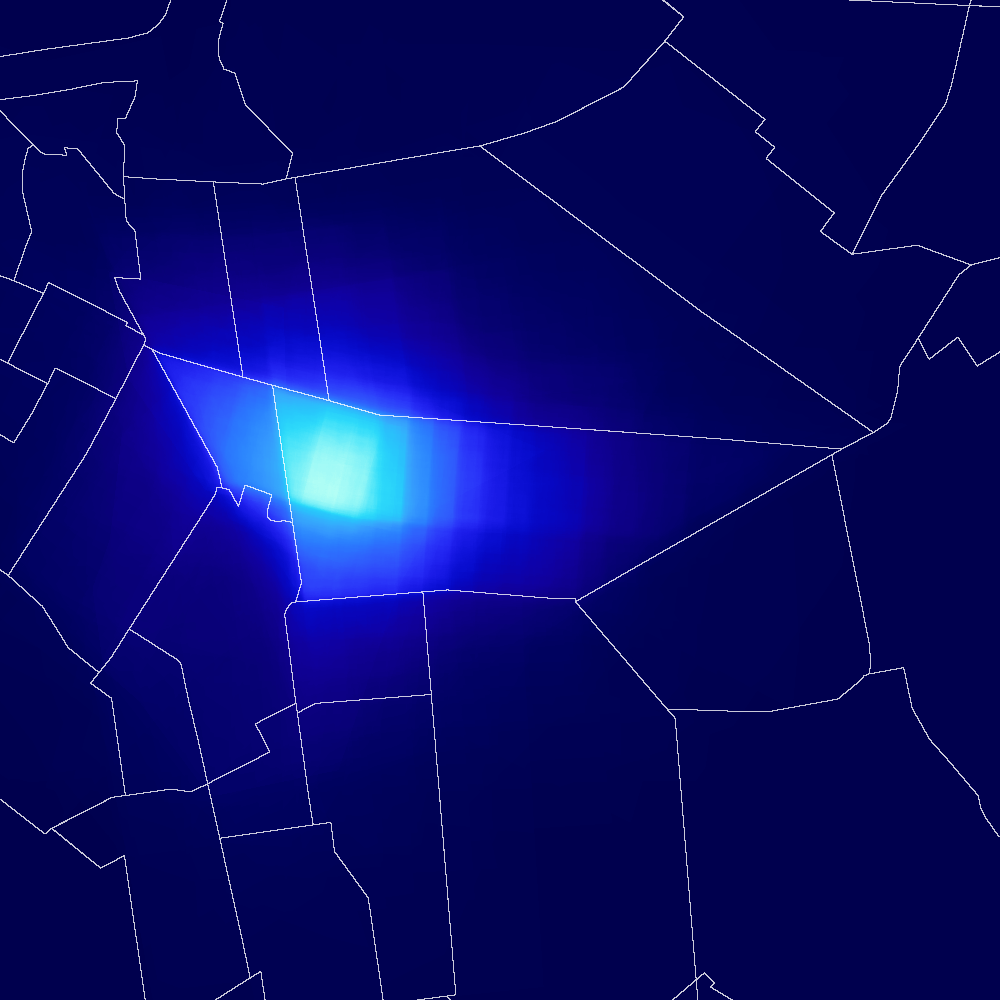

In [158]:
tf.stack(
    tf.shade(df, how='linear', cmap=kbc, name='Density'),
    tf.shade(bd, how='eq_hist', cmap=['black','white'], alpha=200)
)